In [2]:
import numpy as np
import pydicom
import os
import matplotlib.pyplot as plt
from glob import glob
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import scipy.ndimage
from skimage import morphology
from skimage import measure
from skimage.transform import resize
from sklearn.cluster import KMeans
from skimage import filters

import tensorflow as tf
from tensorflow.keras import Model, Sequential 
from tensorflow.keras.utils import Sequence
from tensorflow.keras.layers import Conv2D, MultiHeadAttention, AveragePooling2D, GlobalAveragePooling2D, MaxPooling2D , Conv3D, Layer, MaxPooling2D, Dropout, Flatten, Dense, GRU, ConvLSTM2D, Input, BatchNormalization, TimeDistributed, MaxPooling3D, Bidirectional, LSTM
from tensorflow.keras.optimizers import Adam
from random import shuffle
from tensorflow.keras.regularizers import l2

# from tensorflow_docs.vis import embed
from tensorflow.keras import layers
from tensorflow import keras
from keras.models import Model, load_model


# import cv2
# import imageio
# import cv2

import numpy as np
import os
import sys

import matplotlib.pyplot as plt
import pandas as pd
# import seaborn as sns
# import IPython
# from six.moves import urllib
print(tf.__version__)
print(keras.__version__)
import pydicom
import re
import math
import random
# import bisect
np.random.seed(1234)
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
import warnings
warnings.filterwarnings(action='once')

MAX_SEQ_LENGTH = 200
NUM_FEATURES = 1024
IMG_SIZE = 512
BATCH_SIZE = 4
EPOCHS = 2
NUM_SCANS = 8
NUM_CHANNELS = 1
INPUT_DIM = 256

keras.utils.set_random_seed(1)
random.seed(1)
np.random.seed(1)

2.8.1
2.8.0
Num GPUs Available:  1


In [2]:
test = pd.read_csv('/home/data/pe/test.csv')

In [144]:
pos = pd.read_csv('/home/data/new_PE_annotations/PE_positive_labels_April_2022.csv')

In [138]:
sample.id.isin(all_ids.StudyInstanceUID).sum()

0

In [143]:
all_ids.StudyInstanceUID.isin(test.StudyInstanceUID).sum()

0

In [147]:
pos.StudyInstanceUID.isin(test.StudyInstanceUID).sum()

0

In [3]:
fold = 0
all_ids = pd.read_csv('all_ids_updated.csv')
all_ids.ycoord = all_ids.ycoord.replace('True', '1.0').astype('float')
all_ids = all_ids.drop_duplicates('StudyInstanceUID')
fold_df = pd.read_csv('folds.csv')

directory = '/home/shared/nps/coat_np_0' + str(fold) + '/'

lisdir = os.listdir(directory)
print('hello?')
print(len(lisdir))

files = pd.DataFrame({'file_name':lisdir})
files['StudyInstanceUID'] = files['file_name'].str.replace('.npy','')
files = pd.merge(files, all_ids)
files = files.drop(columns=['SeriesInstanceUID', 'SOPInstanceUID',
       'pe_present_on_image','ycoord', 'contains_lung'])
files = pd.merge(files, fold_df)
    

/tmp/ipykernel_3552920/3829534473.py:2: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  all_ids = pd.read_csv('all_ids_updated.csv')


hello?
6813


/tmp/ipykernel_3552920/3829534473.py:14: FutureWarning: The default value of regex will change from True to False in a future version.
  files['StudyInstanceUID'] = files['file_name'].str.replace('.npy','')


In [4]:
num_features = 64
MAX_SEQ_LENGTH = 200

class DataGenerator(Sequence):
    """Generates data for Keras
    Sequence based data generator. Suitable for building data generator for training and prediction.
    """
    def __init__(self, list_IDs, study_ids, num_features, directory,
                 seq_length, return_type = 'both', to_fit=True, batch_size=32, 
                 shuffle=True, full_set = None, random=False, set_type='test',
                 feat_type = 'feats', oversample=True, crop=False ):

        self.list_IDs = list_IDs
        self.study_ids = study_ids
        self.to_fit = to_fit
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.num_features = num_features
        self.seq_length = seq_length
        self.full_set = full_set
        self.return_type = return_type
        self.random = random
        warnings.filterwarnings(action='ignore')
        self.directory = directory
        self.set_type = set_type
        self.feat_type = feat_type
        self.oversample=oversample
        self.crop= crop
        
        if self.set_type == 'val':
            sample_pos = self.full_set[self.full_set.negative_exam_for_pe == False]
            sample_neg = self.full_set[self.full_set.negative_exam_for_pe == True]
            self.study_ids = pd.concat([sample_pos, sample_neg.sample(n=len(sample_pos))]).sample(frac = 1).reset_index(drop=True)
            self.list_IDs = np.arange(0, len(self.study_ids))
        self.on_epoch_end()
            
        
    def __len__(self):
        """Denotes the number of batches per epoch
        :return: number of batches per epoch
        """
        return int(np.floor(len(self.list_IDs) / self.batch_size))


    def __getitem__(self, index):
#         print('starting')
        indexes = self.list_IDs[index * self.batch_size:((index+1) * self.batch_size)]
        x_feats = np.zeros([self.batch_size, self.seq_length, self.num_features])
        y_seq = np.zeros([self.batch_size, self.seq_length, 1])
        y_tot = np.zeros([self.batch_size, 1])
        for i in range(0,self.batch_size):
            x, y = self._get_scan_data(self.study_ids.iloc[indexes[i]].StudyInstanceUID)
            x_feats[i] = x
            y_seq[i] = y[0]
            y_tot[i] = y[1]
            
        if self.to_fit:
            if self.return_type =='both':
                y = [np.array(y_seq), y_tot]
            elif self.return_type == 'seq':
                y = y_seq
            elif self.return_type == 'tot':
                y = y_tot
            else:
                print('valid return types are both, seq and tot')
                return False
            x = x_feats
            return x, y
        else:
            return (X)
        
    def on_epoch_end(self):
        """Updates indexes after each epoch
        """
        if self.set_type == 'train':
            sample_pos = self.full_set[self.full_set.negative_exam_for_pe == False]
            sample_neg = self.full_set[self.full_set.negative_exam_for_pe == True]
            if self.oversample == False:
                self.study_ids = pd.concat([sample_pos, sample_neg.sample(n=len(sample_pos))]).sample(frac=1).reset_index(drop=True)
            else:
                self.study_ids = pd.concat([sample_pos.sample(n=len(sample_neg), replace=True), sample_neg]).sample(frac = 1).reset_index(drop=True)
            self.list_IDs = np.arange(0, len(self.study_ids))
        if self.shuffle == True:
            np.random.shuffle(self.list_IDs)
            
    def _get_scan_data(self, study_id):
        scan = pd.DataFrame(np.load(self.directory +study_id + '.npy', allow_pickle=True).tolist())
        scan.ycoord = scan.ycoord.replace('True', '1.0').astype('float')
        scan = scan.sort_values(by=['ycoord'], ascending=False).reset_index(drop=True)
        
        features = scan.features.tolist()
        seq = scan.pe_present_on_image.tolist()
        seq = np.reshape(seq, [len(seq),1])
        tot = self.study_ids[self.study_ids.StudyInstanceUID == study_id].negative_exam_for_pe.iloc[0]
        
        if self.set_type == 'train' and self.random == True:
            new_len = int(len(scan) * (random.random()*0.25 +0.9))
            inst = np.round(np.arange(0,new_len)/new_len*len(features)).astype(int)
            features = (np.array(features)[inst]).tolist()
            seq = seq[inst]   
            
            new_len = int(len(features)*(1 - np.random.random() * 0.05))
            new_start = int(np.random.random() * (len(features)- new_len))
            features = features[new_start:new_start+new_len]
            seq = seq[new_start:new_start+new_len]        
        
        
        if len(features)>=self.seq_length:
            if self.crop==False:
                inst = np.round(np.arange(0,self.seq_length)/self.seq_length*len(features)).astype(int)
                xs = (np.array(features)[inst]).tolist()
                ys = seq[inst]
            if self.crop==True:
                xs = (np.array(features)[:self.seq_length]).tolist()
                ys = seq[:self.seq_length]
        else:
            xs = np.zeros([self.seq_length, self.num_features])
            ys = np.zeros([self.seq_length, 1])

            start = int(np.floor((self.seq_length - len(features))/2))
            end = start + len(features)
            xs[start:end] = features
            ys[start:end] = seq

        ys = ys.tolist()
                    
        return (xs, [ys, tot])

    
def get_generators(df, fold, batch_size, out, feat, random, seq_len=200, crop=True, np_dir='/home/shared/coat_np_0', osa=True, test_only=False):

    dire = np_dir + str(fold) + '/'

    if test_only:
        return DataGenerator(np.arange(0, len(df)),
                                    df, 
                                    64,
                                    dire,
                                    seq_len,
                                    batch_size=batch_size,
                                    set_type = 'test',
                                    return_type=out,
                                    feat_type=feat,
                                    crop=crop,
                                    shuffle=False)
    
    test_df = df[df.fold == fold]
    train_df = df[df.fold != fold]
        
    print(train_df.fold.unique())
    print(test_df.fold.unique())
    test_generator = DataGenerator(np.arange(0, len(test_df)),
                                    test_df, 
                                    64,
                                    dire,
                                    seq_len,
                                    batch_size=batch_size,
                                    set_type = 'test',
                                    return_type=out,
                                    feat_type=feat,
                                    crop=crop)
    
    val_generator = DataGenerator(np.arange(0, len(test_df)),
                                  test_df, 
                                  64,
                                  dire,
                                  seq_len,
                                  batch_size=batch_size,
                                  set_type ='val',
                                  full_set=test_df,
                                  return_type=out,
                                  feat_type=feat,
                                  crop=crop)
    
    train_generator = DataGenerator(np.arange(0, len(train_df)),
                                  train_df, 
                                  64,
                                  dire,
                                  seq_len,
                                  batch_size=batch_size,
                                  set_type ='train',
                                  full_set = train_df,
                                  random = random,
                                  return_type=out,
                                  feat_type=feat,
                                  crop=crop,
                                  oversample=osa)
    
    return train_generator, val_generator, test_generator

In [5]:
def get_attn_lstm(seq_len, noise=0.001):
        num_heads = 1
        key_dim = 8
        inputs = keras.Input(shape=(seq_len, 64))
        x = layers.BatchNormalization()(inputs)
        x = layers.GaussianNoise(noise)(x)
        x = layers.TimeDistributed(layers.Dropout(0.3))(x)
        attn = layers.MultiHeadAttention(num_heads=num_heads,
                                                     key_dim=key_dim, 
                                                     dropout=0.4
                                                    )(x, x)
        attn = layers.LayerNormalization()(attn)
        x = layers.Add()((x,attn))
        x = layers.TimeDistributed(layers.Dropout(0.4))(x)
        x = layers.Bidirectional(layers.LSTM(units=8, 
                                             return_sequences=True,
                                             dropout=0.3, 
                                             recurrent_regularizer=keras.regularizers.L2(0.01),
                                            ))(x)
        x = layers.TimeDistributed(layers.Dropout(0.4))(x)
        x = layers.LSTM(units=8, return_sequences=True,
                        dropout=0.3, 
#                         bias_regularizer=keras.regularizers.L2(0.005)
                       )(x)
        x = layers.TimeDistributed(layers.Dropout(0.4))(x)
        x = layers.Bidirectional(layers.LSTM(units=8,
                                             return_sequences=False, 
                                             dropout=0.3,
#                                              bias_regularizer=keras.regularizers.L2(0.005),
                                            ))(x)
        x = layers.Dropout(0.4)(x)
        stack_outputs = layers.Dense(1, activation='sigmoid', name='tot_out')(x)

        model = keras.models.Model(inputs=inputs, outputs=stack_outputs)
        

        return model

In [6]:
files = files[files.indeterminate == False].reset_index(drop=True)

In [7]:
seq_len = 208
from sklearn.metrics import confusion_matrix
from sklearn import metrics

In [40]:
seq_len = 208
from sklearn.metrics import confusion_matrix
from sklearn import metrics


folds = [2,4,5,7]
for fold in folds:
    for cnt in [1,6,-2,-1]:
        
        tf.keras.backend.clear_session()

        keras.utils.set_random_seed(cnt + 2)
        random.seed(cnt+2)
        np.random.seed(cnt+2)

        model = get_attn_lstm(seq_len, noise=0.005)

        np_dir = '/home/shared/nps/coat_np_0'

        batch_size = 32
        training_gen, validation_gen, test_gen = get_generators(files, fold, 
                                                                batch_size, 
                                                                'tot', 
                                                                'feats', 
                                                                True, 
                                                                seq_len=seq_len, 
                                                                np_dir=np_dir, 
                                                                crop=False,
                                                                osa=False
                                                               )

        lr = 0.001
        opt = keras.optimizers.Nadam(learning_rate=lr)#,beta_1=0.9, beta_2=0.999, decay=0.01)
        scheduler = keras.optimizers.schedules.ExponentialDecay(lr, 2000,0.99)
        scheduler = keras.callbacks.LearningRateScheduler(scheduler)
        
        es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

        model.compile(
                optimizer=opt,
                loss=keras.losses.binary_crossentropy,
                metrics=["accuracy",]
            )

        model.summary()

        checkpoint_filepath = '/home/shared/model_checkpoint_paige/scan/reg5-kfold_0'+str(fold)
        checkpoint = keras.callbacks.ModelCheckpoint(
            checkpoint_filepath, save_weights_only=True, save_best_only=True, verbose=1
        )

        history = model.fit(
            training_gen, 
            validation_data = validation_gen,
            epochs=15,
            callbacks=[checkpoint,scheduler,
                       es
                      ],
        )

        df_hist = pd.DataFrame(history.history)
        df_hist.to_csv('/home/shared/model_checkpoint_paige/scan/hist-reg5-kfold_0'+str(fold)+'.csv')
        
        _,_, test_gen = get_generators(files, fold,  1,  'tot', 'feats', 
                                       True,  seq_len=seq_len, np_dir=np_dir, 
                                       crop=False, osa=False)
        
        t_len = test_gen.__len__()
        x_test = np.zeros([t_len,208,num_features])
        y_test = np.zeros([t_len,1])
        for i in range(0,t_len):
            x_test[i],y= test_gen.__getitem__(i)
            y_test[i] = y

        model.load_weights(checkpoint_filepath)
        y_pred = model(x_test, training=False)
        
        cm = confusion_matrix(y_test, np.asarray(y_pred).round())

        sepecifity = cm[1][1]/(cm[1][1]+cm[1][0])
        sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
        accuracy = (cm[1][1]+cm[0][0])/(cm[1][1]+cm[1][0]+cm[0][0]+cm[0][1])
        fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=1)
        roc_auc = metrics.auc(fpr, tpr)
        
        print(cm)
        print(sensitivity, sepecifity, accuracy, roc_auc)
        if accuracy > 0.84 and sensitivity > 0.79:
            break      

[0 4 8 6 7 9 1 3 5]
[2]
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 208, 64)]    0           []                               
                                                                                                  
 batch_normalization (BatchNorm  (None, 208, 64)     256         ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 gaussian_noise (GaussianNoise)  (None, 208, 64)     0           ['batch_normalization[0][0]']    
                                                                                                  
 time_distributed (TimeDistribu  (None, 208, 64)     0           ['gau

Epoch 12/15
121/121 [==============================] - ETA: 0s - loss: 0.3236 - accuracy: 0.8742
Epoch 12: val_loss did not improve from 0.37276
121/121 [==============================] - 37s 302ms/step - loss: 0.3236 - accuracy: 0.8742 - val_loss: 0.3960 - val_accuracy: 0.8326 - lr: 9.9994e-04
Epoch 13/15
121/121 [==============================] - ETA: 0s - loss: 0.3014 - accuracy: 0.8840
Epoch 13: val_loss did not improve from 0.37276
121/121 [==============================] - 37s 305ms/step - loss: 0.3014 - accuracy: 0.8840 - val_loss: 0.3806 - val_accuracy: 0.8304 - lr: 9.9994e-04
Epoch 14/15
121/121 [==============================] - ETA: 0s - loss: 0.3020 - accuracy: 0.8781
Epoch 14: val_loss did not improve from 0.37276
121/121 [==============================] - 37s 307ms/step - loss: 0.3020 - accuracy: 0.8781 - val_loss: 0.4134 - val_accuracy: 0.8192 - lr: 9.9993e-04
Epoch 15/15
121/121 [==============================] - ETA: 0s - loss: 0.3104 - accuracy: 0.8758
Epoch 15: val_l

Epoch 9/15
123/123 [==============================] - ETA: 0s - loss: 0.3292 - accuracy: 0.8671
Epoch 9: val_loss did not improve from 0.35660
123/123 [==============================] - 37s 298ms/step - loss: 0.3292 - accuracy: 0.8671 - val_loss: 0.4384 - val_accuracy: 0.8307 - lr: 9.9996e-04
Epoch 10/15
123/123 [==============================] - ETA: 0s - loss: 0.3156 - accuracy: 0.8737
Epoch 10: val_loss did not improve from 0.35660
123/123 [==============================] - 37s 298ms/step - loss: 0.3156 - accuracy: 0.8737 - val_loss: 0.4542 - val_accuracy: 0.8281 - lr: 9.9995e-04
Epoch 11/15
123/123 [==============================] - ETA: 0s - loss: 0.3080 - accuracy: 0.8707
Epoch 11: val_loss did not improve from 0.35660
123/123 [==============================] - 37s 305ms/step - loss: 0.3080 - accuracy: 0.8707 - val_loss: 0.4644 - val_accuracy: 0.8307 - lr: 9.9995e-04
Epoch 12/15
123/123 [==============================] - ETA: 0s - loss: 0.3234 - accuracy: 0.8712
Epoch 12: val_los

Epoch 6/15
123/123 [==============================] - ETA: 0s - loss: 0.3166 - accuracy: 0.8796
Epoch 6: val_loss did not improve from 0.38089
123/123 [==============================] - 36s 297ms/step - loss: 0.3166 - accuracy: 0.8796 - val_loss: 0.3894 - val_accuracy: 0.8307 - lr: 9.9997e-04
Epoch 7/15
123/123 [==============================] - ETA: 0s - loss: 0.3104 - accuracy: 0.8760
Epoch 7: val_loss did not improve from 0.38089
123/123 [==============================] - 37s 299ms/step - loss: 0.3104 - accuracy: 0.8760 - val_loss: 0.4092 - val_accuracy: 0.8281 - lr: 9.9997e-04
Epoch 8/15
123/123 [==============================] - ETA: 0s - loss: 0.3149 - accuracy: 0.8737
Epoch 8: val_loss did not improve from 0.38089
123/123 [==============================] - 38s 306ms/step - loss: 0.3149 - accuracy: 0.8737 - val_loss: 0.3829 - val_accuracy: 0.8307 - lr: 9.9996e-04
Epoch 9/15
123/123 [==============================] - ETA: 0s - loss: 0.3040 - accuracy: 0.8760
Epoch 9: val_loss did 

123/123 [==============================] - 37s 299ms/step - loss: 0.3914 - accuracy: 0.8704 - val_loss: 0.4458 - val_accuracy: 0.8307 - lr: 1.0000e-03
Epoch 3/15
123/123 [==============================] - ETA: 0s - loss: 0.3456 - accuracy: 0.8725
Epoch 3: val_loss did not improve from 0.44576
123/123 [==============================] - 37s 300ms/step - loss: 0.3456 - accuracy: 0.8725 - val_loss: 0.4732 - val_accuracy: 0.8281 - lr: 9.9999e-04
Epoch 4/15
123/123 [==============================] - ETA: 0s - loss: 0.3325 - accuracy: 0.8671
Epoch 4: val_loss did not improve from 0.44576
123/123 [==============================] - 38s 306ms/step - loss: 0.3325 - accuracy: 0.8671 - val_loss: 0.4895 - val_accuracy: 0.8229 - lr: 9.9998e-04
Epoch 5/15
123/123 [==============================] - ETA: 0s - loss: 0.3232 - accuracy: 0.8780
Epoch 5: val_loss improved from 0.44576 to 0.43108, saving model to /home/shared/model_checkpoint_paige/scan/reg5-kfold_04
123/123 [==============================] -

                                                                                                  
 tot_out (Dense)                (None, 1)            17          ['dropout_4[0][0]']              
                                                                                                  
Total params: 9,097
Trainable params: 8,969
Non-trainable params: 128
__________________________________________________________________________________________________
Epoch 1/15
123/123 [==============================] - ETA: 0s - loss: 0.5857 - accuracy: 0.8084
Epoch 1: val_loss improved from inf to 0.52392, saving model to /home/shared/model_checkpoint_paige/scan/reg5-kfold_04
123/123 [==============================] - 46s 317ms/step - loss: 0.5857 - accuracy: 0.8084 - val_loss: 0.5239 - val_accuracy: 0.7995 - lr: 0.0010
Epoch 2/15
123/123 [==============================] - ETA: 0s - loss: 0.3889 - accuracy: 0.8620
Epoch 2: val_loss improved from 0.52392 to 0.43173, saving model to /home/sh

                                                                                                  
 time_distributed_2 (TimeDistri  (None, 208, 16)     0           ['bidirectional[0][0]']          
 buted)                                                                                           
                                                                                                  
 lstm_1 (LSTM)                  (None, 208, 8)       800         ['time_distributed_2[0][0]']     
                                                                                                  
 time_distributed_3 (TimeDistri  (None, 208, 8)      0           ['lstm_1[0][0]']                 
 buted)                                                                                           
                                                                                                  
 bidirectional_1 (Bidirectional  (None, 16)          1088        ['time_distributed_3[0][0]']     
 )        

 multi_head_attention (MultiHea  (None, 208, 64)     2136        ['time_distributed[0][0]',       
 dAttention)                                                      'time_distributed[0][0]']       
                                                                                                  
 layer_normalization (LayerNorm  (None, 208, 64)     128         ['multi_head_attention[0][0]']   
 alization)                                                                                       
                                                                                                  
 add (Add)                      (None, 208, 64)      0           ['time_distributed[0][0]',       
                                                                  'layer_normalization[0][0]']    
                                                                                                  
 time_distributed_1 (TimeDistri  (None, 208, 64)     0           ['add[0][0]']                    
 buted)   

In [53]:
dos5

,fold,auc,sensitivity,specificity,accuracy,npv,ppv
0,0.0,0.916162,0.819095,0.884615,0.865067,0.92,0.751152
1,1.0,0.904398,0.793578,0.870246,0.845113,0.896313,0.748918
2,2.0,0.901638,0.800885,0.867117,0.844776,0.895349,0.754167
3,3.0,0.885279,0.763033,0.904656,0.859517,0.89083,0.789216
4,4.0,0.90409,0.78744,0.87931,0.850969,0.902655,0.744292
5,5.0,0.92723,0.812207,0.918142,0.884211,0.912088,0.82381
6,6.0,0.908468,0.805825,0.908096,0.87632,0.912088,0.798077
7,7.0,0.911906,0.821138,0.87799,0.856928,0.892944,0.798419
8,8.0,0.907459,0.801762,0.913043,0.875,0.898649,0.827273
9,9.0,0.895629,0.762332,0.88964,0.847076,0.881696,0.776256


[2 4 8 6 7 9 1 3 5]
[0]
Sensitivity:81.91 
Specificity:88.46 
PPV:75.12 
NPV:92.0 
Accuracy:86.51 
Loss:0.3553
[[163  36]
 [ 54 414]]
[0 2 4 8 6 7 9 3 5]
[1]
Sensitivity:79.36 
Specificity:87.02 
PPV:74.89 
NPV:89.63 
Accuracy:84.51 
Loss:0.3782
[[173  45]
 [ 58 389]]
[0 4 8 6 7 9 1 3 5]
[2]
Sensitivity:80.09 
Specificity:86.71 
PPV:75.42 
NPV:89.53 
Accuracy:84.48 
Loss:0.364
[[181  45]
 [ 59 385]]
[0 2 4 8 6 7 9 1 5]
[3]
Sensitivity:76.3 
Specificity:90.47 
PPV:78.92 
NPV:89.08 
Accuracy:85.95 
Loss:0.376
[[161  50]
 [ 43 408]]
[0 2 8 6 7 9 1 3 5]
[4]
Sensitivity:78.74 
Specificity:87.93 
PPV:74.43 
NPV:90.27 
Accuracy:85.1 
Loss:0.3669
[[163  44]
 [ 56 408]]
[0 2 4 8 6 7 9 1 3]
[5]
Sensitivity:81.22 
Specificity:91.81 
PPV:82.38 
NPV:91.21 
Accuracy:88.42 
Loss:0.3176
[[173  40]
 [ 37 415]]
[0 2 4 8 7 9 1 3 5]
[6]
Sensitivity:80.58 
Specificity:90.81 
PPV:79.81 
NPV:91.21 
Accuracy:87.63 
Loss:0.3317
[[166  40]
 [ 42 415]]
[0 2 4 8 6 9 1 3 5]
[7]
Sensitivity:82.11 
Specificity:87.8 

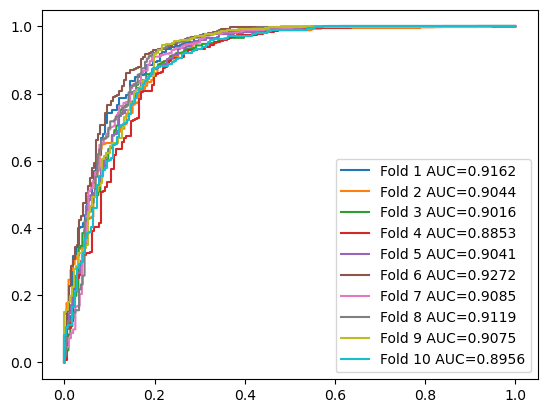

In [24]:
seq_len=208
dos5 = pd.DataFrame(columns=['fold','auc','sensitivity', 'specificity', 'accuracy','npv','ppv'])
files_test = files
tot = 0
caught = 0

no = 0
nope = 0

plt.figure(0).clf()
for fold in range(0,10):

    model = get_attn_lstm(seq_len)

    np_dir = '/home/shared/nps/coat_np_0'

    batch_size = 1
    _,_, test_gen = get_generators(files, fold, 
                                   batch_size, 
                                   'tot', 
                                   'feats', 
                                   True, 
                                   seq_len=seq_len, 
                                   np_dir=np_dir, 
                                   crop=False,
                                   osa=False)
    
    
    t_len = test_gen.__len__()
    x_test = np.zeros([t_len,208,num_features])
    y_test = np.zeros([t_len,1])
    for i in range(0,t_len):
        x_test[i],y= test_gen.__getitem__(i)
        y_test[i] = y
        
    lr = 0.001
    opt = keras.optimizers.Nadam(learning_rate=lr)
    model.compile(
            optimizer=opt,
            loss=keras.losses.binary_crossentropy,
            metrics=["accuracy",]
        )

#     if fold != 9:
    checkpoint_filepath = '/home/shared/model_checkpoint_paige/scan/reg5-kfold_0'+str(fold)
#     else:
#         checkpoint_filepath = '/home/shared/model_checkpoint_paige/scan/reg-kfold_0'+str(fold)
    model.load_weights(checkpoint_filepath).expect_partial()
    
    (fpr,tpr), data, cm = test_version(model, x_test,y_test)
    
    auc = metrics.auc(fpr, tpr)
    plt.plot(fpr,tpr, label='Fold '+str(fold +1)+' AUC={:.4f}'.format(auc))

    #     plt.show(plot)
    tot = tot + cm[0].sum()
    caught = caught + cm[0][0]
    
    no = no + cm[1].sum()
    nope = nope + cm[1][1]
    dos5 = dos5.append({'fold':fold,'auc':data[0],'sensitivity':data[1], 'specificity':data[2], 'accuracy':data[3], 'npv':data[4],'ppv':data[5]}, ignore_index=True)
plt.legend()
plt.show()

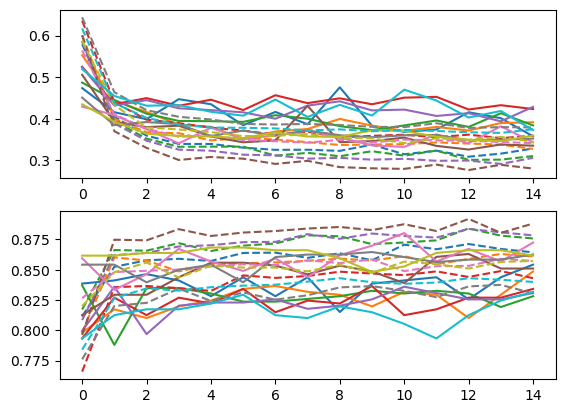

In [52]:
fig, axs = plt.subplots(2)
colours = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

for fold in range(0,10):

    if fold != 9:
        hist = pd.read_csv('/home/shared/model_checkpoint_paige/scan/hist-reg5-kfold_0'+str(fold)+'.csv')
    else:
        hist = pd.read_csv('/home/shared/model_checkpoint_paige/scan/hist-reg4-kfold_0'+str(fold)+'.csv')    
    axs[0].plot(np.arange(0,len(hist)),hist.val_loss, colours[fold], label='Fold '+str(fold))
    axs[0].plot(np.arange(0,len(hist)),hist.loss, colours[fold], linestyle='dashed', label='Fold '+str(fold))

    axs[1].plot(np.arange(0,len(hist)),hist.val_accuracy, colours[fold], label='Fold '+str(fold))
    axs[1].plot(np.arange(0,len(hist)),hist.accuracy, colours[fold], linestyle='dashed', label='Fold '+str(fold))

#     #     plt.show(plot)
#     tot = tot + cm[0].sum()
#     caught = caught + cm[0][0]
    
#     no = no + cm[1].sum()
#     nope = nope + cm[1][1]
#     dos5 = dos5.append({'fold':fold,'auc':data[0],'sensitivity':data[1], 'specificity':data[2], 'accuracy':data[3], 'npv':data[4],'ppv':data[5]}, ignore_index=True)
# plt.legend()

In [14]:
seq_len = NUM_SLICES = 96
ENCODING_DIM = 64

dt = pd.DataFrame(columns=['fold','auc','sensitivity', 'specificity', 'accuracy','npv','ppv'])
files_test = files
tot = 0
caught = 0

no = 0
nope = 0

for fold in range(0,10):

    model = get_model()

    batch_size = 1
    _,_, test_gen = get_turku_generators(files,fold,1)
    
    t_len = test_gen.__len__()
    x_test = np.zeros([t_len,96,num_features])
    y_test = np.zeros([t_len,1])
    for i in range(0,t_len):
        x_test[i],y= test_gen.__getitem__(i)
        y_test[i] = y[1]
        
    lr = 0.001
    opt = keras.optimizers.Nadam(learning_rate=lr)
    model.compile(
            optimizer=opt,
            loss=keras.losses.binary_crossentropy,
            metrics=["accuracy",]
        )

    checkpoint_filepath = '/home/shared/model_checkpoint_paige/scan/turku_fold_0'+str(fold)
    model.load_weights(checkpoint_filepath)
#     .expect_patial()
    
    plot, data, cm = test_version(model, x_test,y_test, turku=True)
    tot = tot + cm[0].sum()
    caught = caught + cm[0][0]
    
    no = no + cm[1].sum()
    nope = nope + cm[1][1]
    dt = dt.append({'fold':fold,'auc':data[0],'sensitivity':data[1], 'specificity':data[2], 'accuracy':data[3], 'npv':data[4],'ppv':data[5]}, ignore_index=True)

[2 4 8 6 7 9 1 3 5]
[0]


2023-01-19 15:46:28.238703: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8401


Sensitivity:79.9 
Specificity:84.4 
PPV:68.53 
NPV:90.8 
Accuracy:83.06 
Loss:0.4822
[[159  40]
 [ 73 395]]
[0 2 4 8 6 7 9 3 5]
[1]
Sensitivity:69.27 
Specificity:93.96 
PPV:84.83 
NPV:86.24 
Accuracy:85.86 
Loss:0.4399
[[151  67]
 [ 27 420]]
[0 4 8 6 7 9 1 3 5]
[2]
Sensitivity:66.81 
Specificity:87.84 
PPV:73.66 
NPV:83.87 
Accuracy:80.75 
Loss:0.5095
[[151  75]
 [ 54 390]]
[0 2 4 8 6 7 9 1 5]
[3]
Sensitivity:68.72 
Specificity:88.25 
PPV:73.23 
NPV:85.78 
Accuracy:82.02 
Loss:0.4987
[[145  66]
 [ 53 398]]
[0 2 8 6 7 9 1 3 5]
[4]
Sensitivity:70.53 
Specificity:91.16 
PPV:78.07 
NPV:87.4 
Accuracy:84.8 
Loss:0.4548
[[146  61]
 [ 41 423]]
[0 2 4 8 6 7 9 1 3]
[5]
Sensitivity:72.3 
Specificity:91.37 
PPV:79.79 
NPV:87.5 
Accuracy:85.26 
Loss:0.4581
[[154  59]
 [ 39 413]]
[0 2 4 8 7 9 1 3 5]
[6]
Sensitivity:62.14 
Specificity:91.03 
PPV:75.74 
NPV:84.21 
Accuracy:82.05 
Loss:0.4838
[[128  78]
 [ 41 416]]
[0 2 4 8 6 9 1 3 5]
[7]
Sensitivity:77.64 
Specificity:84.93 
PPV:75.2 
NPV:86.59 
Acc

[0 2 4 6 7 9 1 3 5]
[8]
Sensitivity:70.48 
Specificity:92.22 
PPV:82.47 
NPV:85.74 
Accuracy:84.79 
Loss:0.4376
[[160  67]
 [ 34 403]]
[0 2 4 8 6 7 1 3 5]
[9]
Sensitivity:72.2 
Specificity:85.14 
PPV:70.93 
NPV:85.91 
Accuracy:80.81 
Loss:0.5034
[[161  62]
 [ 66 378]]


In [25]:
from scipy.stats import ranksums
for col in dos5.columns:
    print(col)
    print(ranksums(dos5[col], dt[col]))
    print(dos5[col].mean(), dt[col].mean())
    print()


fold
RanksumsResult(statistic=0.0, pvalue=1.0)
4.5 4.5

auc
RanksumsResult(statistic=3.6284589408885815, pvalue=0.00028511808363161265)
0.9062258912153782 0.8644019975248968

sensitivity
RanksumsResult(statistic=3.3260873624811995, pvalue=0.000880743190741727)
0.7967295183645524 0.7099920510897142

specificity
RanksumsResult(statistic=-0.15118578920369088, pvalue=0.8798291600118298)
0.891285667239214 0.8902945811549448

accuracy
RanksumsResult(statistic=2.6457513110645907, pvalue=0.008150971593502691)
0.8604976144967637 0.8316344854469613

npv
RanksumsResult(statistic=3.250494467879354, pvalue=0.0011520450981421845)
0.9002611703169725 0.8640400854511905

ppv
RanksumsResult(statistic=0.9827076298239908, pvalue=0.3257513544787166)
0.7811578267288313 0.7624602479750144



In [183]:
fold = 1
all_fold = all_pred[all_pred.fold == fold]
print((all_fold[all_fold.negative_exam_for_pe == True].pred >0.5).mean())
print((all_fold[all_fold.negative_exam_for_pe == False].pred <0.5).mean())

0.9194630872483222
0.7094017094017094


In [81]:
all_neg = all_pred[all_pred.negative_exam_for_pe == True]
all_pos = all_pred[all_pred.negative_exam_for_pe == False]

In [82]:
(all_pos.pred < 0.5).sum()/len(all_pos),(all_neg.pred > 0.5).sum()/len(all_neg)

(0.7950367647058824, 0.8984828201695672)

In [85]:
len(all_pos), len(all_pos[all_pos.pred < 0.5])

(2176, 1730)

In [31]:
(all_pos[all_pos.central_pe == True].pred <0.5).mean(), (all_pos[(all_pos.central_pe == False) &((all_pos.leftsided_pe == True) & (all_pos.rightsided_pe ==True))].pred < 0.5).mean(), (all_pos[(all_pos.central_pe == False) & ((all_pos.leftsided_pe == False) | (all_pos.rightsided_pe ==False))].pred < 0.5).mean()

(0.9724310776942355, 0.8640093786635404, 0.6255411255411255)

In [177]:
all_false_neg = all_pos[all_pos.pred > 0.5]
all_true_pos = all_pos[all_pos.pred < 0.5]

all_false_pos = all_neg[all_neg.pred < 0.5]
all_true_neg = all_neg[all_neg.pred > 0.5]

In [176]:
len(all_pos[(all_pos.pred > 0.5) & ((all_pos.qa_contrast == True) | (all_pos.qa_motion== True))])/len(all_pos[all_pos.pred >0.5])

0.17582417582417584

In [167]:
(all_pos[(all_pos.qa_contrast == False) & (all_pos.qa_motion == False)].pred < 0.5).mean()

0.7931985294117647

In [89]:
col = 'central_pe'
(all_pos[all_pos[col] == True].pred <0.5).sum()/len(all_pos[all_pos[col] == True]),(all_pos[all_pos[col] == False].pred <0.5).sum()/len(all_pos[all_pos[col] == False]),len(all_pos[all_pos[col]==True]),len(all_pos[(all_pos.pred < 0.5) & (all_pos[col]==True)])

(0.974937343358396, 0.7546426561620709, 399, 389)

In [100]:
(all_pos[(all_pos.central_pe == False) & (all_pos.leftsided_pe == True) & (all_pos.rightsided_pe == True)].pred <0.5).sum()/len(all_pos[(all_pos.central_pe == False) & (all_pos.leftsided_pe == True) & (all_pos.rightsided_pe == True)]),(all_pos[(all_pos.central_pe == False) & ((all_pos.leftsided_pe == True) ^ (all_pos.rightsided_pe == True))].pred <0.5).sum()/len(all_pos[(all_pos.central_pe == False) & ((all_pos.leftsided_pe == True) ^ (all_pos.rightsided_pe == True))])

(0.8733880422039859, 0.645021645021645)

In [159]:
col = 'acute_and_chronic_pe'
(all_pos[all_pos[col] == True].pred <0.5).sum()/len(all_pos[all_pos[col] == True]),(all_pos[all_pos[col] == False].pred <0.5).sum()/len(all_pos[all_pos[col] == False]),len(all_pos[all_pos[col]==True])

(0.8881118881118881, 0.7568807339449541, 143)

In [101]:
col = 'flow_artifact'
(all_neg[all_neg[col] == True].pred >0.5).sum()/len(all_neg[all_neg[col] == True]),(all_neg[all_neg[col] == False].pred >0.5).sum()/len(all_neg[all_neg[col] == False]),len(all_neg[all_neg[col]==True])

(0.8260869565217391, 0.901582131223825, 184)

In [102]:
col = 'true_filling_defect_not_pe'
(all_neg[all_neg[col] == True].pred >0.5).mean(),(all_neg[all_neg[col] == False].pred >0.5).mean(),len(all_neg[all_neg[col]==True])

(0.7419354838709677, 0.8995731296337902, 31)

In [103]:
all_neg.mean()

negative_exam_for_pe          1.000000
qa_motion                     0.000000
qa_contrast                   0.000000
flow_artifact                 0.041053
rv_lv_ratio_gte_1             0.000000
rv_lv_ratio_lt_1              0.000000
leftsided_pe                  0.000000
chronic_pe                    0.000000
true_filling_defect_not_pe    0.006917
rightsided_pe                 0.000000
acute_and_chronic_pe          0.000000
central_pe                    0.000000
indeterminate                 0.000000
fold                          4.454261
pred                          0.796277
dtype: float64

In [246]:
all_all_ids = pd.read_csv('all_ids_updated.csv')

In [27]:
1-all_pred.negative_exam_for_pe.mean()

0.34136664217487145

In [23]:
(all_pos[(all_pos.central_pe == False) & ((all_pos.leftsided_pe ==False) ^ (all_pos.rightsided_pe==False))].pred < 0.5).mean()

0.6374458874458875

In [213]:
(all_pos.pred < 0.5).mean(),len(all_pos[(all_pos.rv_lv_ratio_gte_1==False)& (all_pos.rv_lv_ratio_lt_1 == False)]),(all_pos[(all_pos.rv_lv_ratio_gte_1==True)| (all_pos.rv_lv_ratio_lt_1 == True)].pred < 0.5).mean(),(all_pos[(all_pos.rv_lv_ratio_gte_1==False)& (all_pos.rv_lv_ratio_lt_1 == False)].pred < 0.5).mean()

(0.7649591046061128, 147, 0.7931985294117647, 0.3469387755102041)

In [214]:
all_pos[(all_pos.rv_lv_ratio_gte_1 == False) & (all_pos.rv_lv_ratio_lt_1 == False)].mean()

negative_exam_for_pe          0.000000
qa_motion                     0.387755
qa_contrast                   0.775510
flow_artifact                 0.095238
rv_lv_ratio_gte_1             0.000000
rv_lv_ratio_lt_1              0.000000
leftsided_pe                  0.000000
chronic_pe                    0.000000
true_filling_defect_not_pe    0.000000
rightsided_pe                 0.000000
acute_and_chronic_pe          0.000000
central_pe                    0.000000
indeterminate                 1.000000
fold                          4.551020
pred                          0.594196
dtype: float64

In [241]:
(all_neg[all_neg.flow_artifact == True].pred < 0.5).mean()/(all_neg[all_neg.flow_artifact == False].pred < 0.5).mean()

1.6272349780166098

In [242]:
(all_neg[all_neg.true_filling_defect_not_pe == True].pred < 0.5).mean()/(all_neg[all_neg.true_filling_defect_not_pe == False].pred < 0.5).mean()

2.1429947038998556

In [374]:
sub = all_false_neg[all_false_neg.qa_motion== True].StudyInstanceUID

In [257]:
all_all = pd.read_csv('/home/shared/nps/results_0to10.csv')

In [385]:
all_all[(all_all.StudyInstanceUID.isin(sub)) & (all_all.fold == 1) & (all_all.pred_01 > 0.6)].StudyInstanceUID.unique()

array(['1332400aae88', 'bdd1a6ef0a20', 'c4702e3013ef', 'd9e7f4891acd',
       'deeba41e5b29'], dtype=object)

In [273]:
import matplotlib.pyplot as plt
import cv2

In [247]:
len(all_false_pos[(all_false_pos.flow_artifact == True) | (all_false_pos.true_filling_defect_not_pe == True)])/len(all_false_pos)

0.07773109243697479

In [27]:
dos5.mean()

fold           4.500000
auc            0.906226
sensitivity    0.796730
specificity    0.891286
accuracy       0.860498
npv            0.900261
ppv            0.781158
dtype: float64

In [224]:
all_false_pos.mean()

negative_exam_for_pe          1.000000
qa_motion                     0.000000
qa_contrast                   0.000000
flow_artifact                 0.065126
rv_lv_ratio_gte_1             0.000000
rv_lv_ratio_lt_1              0.000000
leftsided_pe                  0.000000
chronic_pe                    0.000000
true_filling_defect_not_pe    0.014706
rightsided_pe                 0.000000
acute_and_chronic_pe          0.000000
central_pe                    0.000000
indeterminate                 0.000000
fold                          4.090336
pred                          0.297252
dtype: float64

In [164]:
(all_pred[all_pred.qa_motion == True].pred > 0.5).mean()/len(all_pred[all_pred.qa_motion == True])

0.631578947368421

In [ ]:
(all_pred[all_pred.qa == True].pred > 0.5).sum()/len(all_pred[all_pred.qa_motion == True])

In [62]:
from scipy.stats import ranksums

In [71]:
for col in dt.columns:
    print(col)
    print(ranksums(dt[col], doo[col]))

fold
RanksumsResult(statistic=0.0, pvalue=1.0)
auc
RanksumsResult(statistic=-3.704051835490427, pvalue=0.00021218287122257823)
sensitivity
RanksumsResult(statistic=-3.4016802570830453, pvalue=0.0006697294490218271)
specificity
RanksumsResult(statistic=0.8315218406202999, pvalue=0.40567889528505297)
accuracy
RanksumsResult(statistic=-2.418972627259054, pvalue=0.015564411386633814)
npv
RanksumsResult(statistic=-3.3260873624811995, pvalue=0.000880743190741727)
ppv
RanksumsResult(statistic=-0.15118578920369088, pvalue=0.8798291600118298)


In [55]:
do.mean(), doo.mean()

(fold           4.500000
 auc            0.895292
 sensitivity    0.765049
 specificity    0.886435
 accuracy       0.844828
 npv            0.879391
 ppv            0.781576
 dtype: float64,
 fold           4.500000
 auc            0.897514
 sensitivity    0.764919
 specificity    0.893941
 accuracy       0.849824
 npv            0.880483
 ppv            0.791557
 dtype: float64)

In [35]:
tot, caught, caught/tot, no ,nope, nope/no

(2323, 1777, 0.7649591046061128, 4482, 4006, 0.8937974118697011)

In [36]:
do.mean()

fold           4.500000
auc            0.897514
sensitivity    0.764919
specificity    0.893941
accuracy       0.849824
npv            0.880483
ppv            0.791557
dtype: float64

In [11]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics

tf.config.experimental.enable_op_determinism()

def test_version(model, x_test, y_test, offset=0, turku=False):

    y_pred = model(x_test, training=False)
        
    if turku == False:
        y_pred = y_pred.numpy() + offset
    else: 
        y_pred = y_pred[1].numpy() + offset
    cm = confusion_matrix(y_test, y_pred.round())
        
    sepecifity = cm[1][1]/(cm[1][1]+cm[1][0])
    sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
    accuracy = (cm[1][1]+cm[0][0])/(cm[1][1]+cm[1][0]+cm[0][0]+cm[0][1])

    ppv = cm[0][0]/(cm[0][0]+cm[1][0])
    npv = cm[1][1]/(cm[1][1]+cm[0][1])
    loss = metrics.log_loss(y_test, y_pred)

    print('Sensitivity:{:.4}'.format(sensitivity*100),
          '\nSpecificity:{:.4}'.format(sepecifity*100),
          '\nPPV:{:.4}'.format(ppv*100),
          '\nNPV:{:.4}'.format(npv*100),
          '\nAccuracy:{:.4}'.format(accuracy*100),
          '\nLoss:{:.4}'.format(loss))
    print(cm)

    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=1)
    roc_auc = metrics.auc(fpr, tpr)
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                      estimator_name='example estimator')
    return (fpr,tpr), [roc_auc, sensitivity, sepecifity, accuracy, npv, ppv], cm

In [ ]:
batch_size = 16
training_generator, validation_generator, test_generator = get_generators(files, fold, batch_size, 'tot', 'feats')

In [10]:
class TurkuGenerator(keras.utils.Sequence):
    def __init__(
        self,
        df: pd.DataFrame,
#         encoding_dict: Dict[str, np.ndarray],
#         filename_col: str,
#         label_col: str,
#         dataset_label_col: str,
        batch_size: int,
        encoding_dim: int,
        directory: str,
        num_slices: int = 96,
        shuffle: bool = True,
    ):
        self.df = df.copy()
        self.series_instance_uids = self.df["StudyInstanceUID"].unique()
        self.count_no_aug_series = len(self.series_instance_uids)
#         self.encoding_dict = encoding_dict
#         self.filename_col = filename_col
#         self.label_col = label_col
#         self.dataset_label_col = dataset_label_col
        self.batch_size = batch_size
        self.encoding_dim = encoding_dim
        self.num_slices = num_slices
        self.shuffle = shuffle
        self.directory = directory

        self.on_epoch_end()

    def __len__(self) -> int:
        return int(np.ceil(self.count_no_aug_series / self.batch_size))

    def __getitem__(self, index: int):
        offset = index * self.batch_size
        indexes = self.indexes[offset : min(offset + self.batch_size, self.df.shape[0])]

        UIDs = [self.series_instance_uids[k] for k in indexes]

        X, ys = self._prepare_batch(UIDs)

        return X, ys

    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        self.indexes = np.arange(len(self.series_instance_uids))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def _prepare_batch(self, UIDs):
        batch_size = len(UIDs)
        X = np.zeros((batch_size, self.num_slices, self.encoding_dim), dtype=np.float32)
        y = np.zeros((batch_size, self.num_slices, 1), dtype=np.int32)
        y_stack = np.zeros((batch_size, 1), dtype=np.int32)

        for i, uid in enumerate(UIDs):

            scan = pd.DataFrame(np.load(self.directory + uid + '.npy', allow_pickle=True).tolist())
            scan.ycoord = scan.ycoord.replace('True', '1.0').astype('float')
            scan = scan.sort_values(by=['ycoord'], ascending=True).reset_index(drop=True)

            features = scan.features.tolist()
            seq = scan.pe_present_on_image.tolist()
            
            if len(features) > self.num_slices:
                X[i] = features[:self.num_slices]
                y[i,:,0] = seq[:self.num_slices]
            else:
                X[i, :len(features), :] = features
                y[i, :len(seq), 0] = seq
            y_stack[i,0] = scan.negative_exam_for_pe.iloc[0]
            
        return X, [y, y_stack]


def get_turku_generators(df, fold, batch_size, np_dir='/home/shared/nps/turku_0'):
    test_df = df[df.fold == fold]
    train_df = df[df.fold != fold]
    
    train_pos = train_df[train_df.negative_exam_for_pe == False]
    train_neg = train_df[train_df.negative_exam_for_pe == True]

    val_pos = test_df[test_df.negative_exam_for_pe == False]
    val_neg = test_df[test_df.negative_exam_for_pe == True]

    train = pd.concat([train_pos, train_neg.sample(n=len(train_pos))]).sample(frac = 1).reset_index(drop=True)
    val = pd.concat([val_pos, val_neg.sample(n=len(val_pos))]).sample(frac = 1).reset_index(drop=True)
    
    print(train_df.fold.unique())
    print(test_df.fold.unique())
    directory = np_dir + str(fold) + '/'

    test_generator = TurkuGenerator(test_df,
                                    batch_size,
                                    64,
                                    directory)
    
    val_generator = TurkuGenerator(val,
                                    batch_size,
                                    64,
                                    directory)
    
    train_generator = TurkuGenerator(train,
                                    batch_size,
                                    64,
                                    directory)
    
    return train_generator, val_generator, test_generator
def get_model() -> keras.models.Model:
    """Get a custom LSTM based model for classifying a set of slice encodings.
    The model predicts presence of PE at both slice and stack level.
    """
    tf.keras.backend.clear_session()

    slice_stack = keras.Input(shape=(NUM_SLICES, ENCODING_DIM))

    x = layers.BatchNormalization()(slice_stack)
    x = layers.Bidirectional(layers.LSTM(units=64, return_sequences=True))(x)
    x = layers.TimeDistributed(layers.Dense(512, activation="relu"))(x)
    x = layers.TimeDistributed(layers.Dense(128, activation="relu"))(x)
    slice_outputs = layers.TimeDistributed(layers.Dense(1, activation="sigmoid"), name="slices")(x)

    reshaped_features = layers.Reshape((NUM_SLICES,))(slice_outputs)
    reshaped_features = layers.Dropout(0.05)(reshaped_features)
    stack_output = layers.Dense(1, activation="sigmoid", name="sequence")(reshaped_features)

    model = keras.models.Model(inputs=slice_stack, outputs=[slice_outputs, stack_output])

    return model


In [23]:
for fold in range(0,10):
    train, val, test = get_turku_generators(files,fold,32)

    NUM_SLICES=96
    ENCODING_DIM = 64
    model = get_model()
    opt = keras.optimizers.Nadam(learning_rate=0.001)
    model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

    model.summary()

    model.fit(
        train,
        validation_data = val,
        epochs=10,
        shuffle=True,
        callbacks=[checkpoint],
    )



[2 4 8 6 7 9 1 3 5]
[0]
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 64)]          0         
                                                                 
 batch_normalization (BatchN  (None, 96, 64)           256       
 ormalization)                                                   
                                                                 
 bidirectional (Bidirectiona  (None, 96, 128)          66048     
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 96, 512)          66048     
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 96, 128)          65664     
 tributed)                           

KeyboardInterrupt: 

In [24]:
model.load_weights(checkpoint_filepath)
# model.evaluate(test_generator)

In [5]:
def get_attn_lstm(noise=True):
        tf.keras.backend.clear_session()
        num_heads = 1
        key_dim = 8
        inputs = keras.Input(shape=(200, 64))
        x = layers.BatchNormalization()(inputs)
        if noise == True:
            x = layers.GaussianNoise(0.001)(x)

        attn = layers.MultiHeadAttention(num_heads=num_heads,
                                                     key_dim=key_dim, 
                                                     dropout=0.3
                                                    )(x, x)
        attn = layers.LayerNormalization()(attn)
        x = layers.Add()((x,attn))
        x = layers.Bidirectional(layers.LSTM(units=8, return_sequences=True, dropout=0.3))(x)
        x = layers.LayerNormalization()(x)
#         x = layers.Bidirectional(layers.LSTM(units=8, return_sequences=True, dropout=0.3))(x)
#         x = layers.LayerNormalization()(x)
        x = layers.TimeDistributed(layers.Dropout(0.3))(x)
        x = layers.TimeDistributed(layers.Dense(16, activation='gelu'))(x)
        x = layers.LayerNormalization()(x)
        x = layers.TimeDistributed(layers.Dropout(0.3))(x)
        x = layers.GlobalMaxPooling1D()(x)
        x = layers.Dropout(0.4)(x)
        stack_outputs = layers.Dense(1, activation='sigmoid', name='tot_out')(x)

        model = keras.models.Model(inputs=inputs, outputs=stack_outputs)
        
        lr = 0.001
        opt = keras.optimizers.Nadam(learning_rate=lr)
        scheduler = keras.optimizers.schedules.ExponentialDecay(lr, 2000,0.99)
        scheduler = keras.callbacks.LearningRateScheduler(scheduler)


        model.compile(
                optimizer=opt,
                loss=keras.losses.binary_crossentropy,
                metrics=["accuracy",]
            )

        return model


[2 4 8 6 7 9 1 3 5]
[0]
Sensitivity:83.1 
Specificity:81.2 
PPV:66.79 
NPV:91.35 
Accuracy:81.79 
Loss:0.5376
[[177  36]
 [ 88 380]]


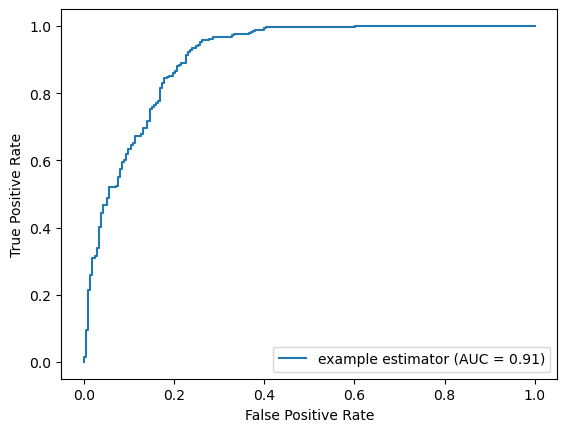

In [18]:
model = get_attn_lstm()

fold = 0
DIR =  '/home/shared/nps/coat_np_0' + str(fold) + '/'

_,_, test_generator = get_generators(files, fold, 1, 'tot', 'feats', random=False)
t_len = test_generator.__len__()
x_test = np.zeros([t_len,200,num_features])
y_test = np.zeros([t_len,1])
for i in range(0,t_len):
    x_test[i],y= test_generator.__getitem__(i)
    y_test[i] = y

# opt = keras.optimizers.Nadam(learning_rate=0.001)
# model.compile(
#     optimizer=opt,
#     loss=keras.losses.binary_crossentropy,
#     metrics=["accuracy"])

checkpoint_filepath = '/home/shared/model_checkpoint_paige/scan/lstm-w-attn-kfold_0'+str(fold)
model.load_weights(checkpoint_filepath)
test_version(model, x_test, y_test,offset=-0.1)

[2 4 8 6 7 9 1 3 5]
[0]


2022-11-29 15:00:20.216470: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


Sensitivity:76.53 
Specificity:91.45 
PPV:80.3 
NPV:89.54 
Accuracy:86.78 
Loss:0.3584
[[163  50]
 [ 40 428]]


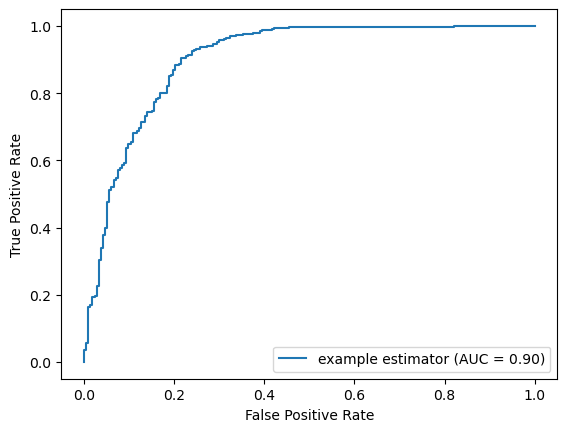

In [13]:
model = get_conv_gru_model()

fold = 0
DIR =  '/home/shared/nps/coat_np_0' + str(fold) + '/'

_,_, test_generator = get_generators(files, fold, 1, 'tot', 'feats', random=False)
t_len = test_generator.__len__()
x_test = np.zeros([t_len,200,num_features])
y_test = np.zeros([t_len,1])
for i in range(0,t_len):
    x_test[i],y= test_generator.__getitem__(i)
    y_test[i] = y

# opt = keras.optimizers.Nadam(learning_rate=0.001)
# model.compile(
#     optimizer=opt,
#     loss=keras.losses.binary_crossentropy,
#     metrics=["accuracy"])

checkpoint_filepath = '/home/shared/model_checkpoint_paige/scan/conv_lstm_kfold_0'
model.load_weights(checkpoint_filepath)
test_version(model, x_test, y_test)

[0 2 4 8 6 7 9 1 5]
[3]
Sensitivity:74.35 
Specificity:90.91 
PPV:80.66 
NPV:87.42 
Accuracy:85.32 
Loss:0.3803
[[171  59]
 [ 41 410]]


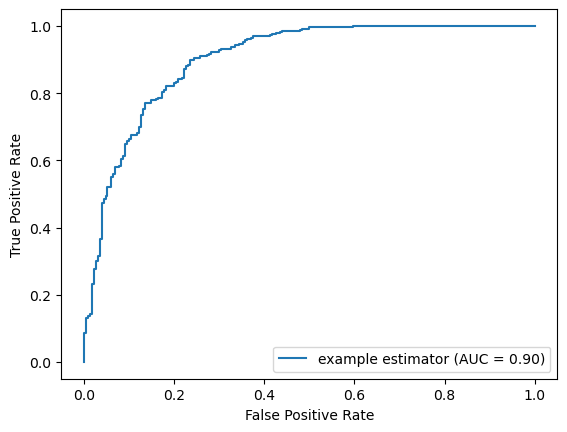

In [11]:
model = get_attn_lstm()

fold = 3
DIR =  '/home/shared/nps/coat_np_0' + str(fold) + '/'

_,_, test_generator = get_generators(files, fold, 1, 'tot', 'feats', random=False)
t_len = test_generator.__len__()
x_test = np.zeros([t_len,200,num_features])
y_test = np.zeros([t_len,1])
for i in range(0,t_len):
    x_test[i],y= test_generator.__getitem__(i)
    y_test[i] = y

# opt = keras.optimizers.Nadam(learning_rate=0.001)
# model.compile(
#     optimizer=opt,
#     loss=keras.losses.binary_crossentropy,
#     metrics=["accuracy"])

checkpoint_filepath = '/home/shared/model_checkpoint_paige/scan/attn_lstm_kfold_3'
model.load_weights(checkpoint_filepath)
test_version(model, x_test, y_test)



In [1]:
# keras.utils.set_random_seed(1)

# model = get_attn_lstm(200,64, 0.4,0.3)

# opt = keras.optimizers.Nadam(learning_rate=0.001)
# model.compile(
#     optimizer=opt,
#     loss=keras.losses.binary_crossentropy,
#     metrics=["accuracy"])
model.load_weights(filepath= '/home/shared/model_checkpoint_paige/scan/lstm-w-attn-kfold_00')
test_version(model,x_test,y_test)


NameError: name 'model' is not defined

Sensitivity:76.53 
Specificity:91.45 
PPV:80.3 
NPV:89.54 
Accuracy:86.78 
Loss:0.3557
[[163  50]
 [ 40 428]]


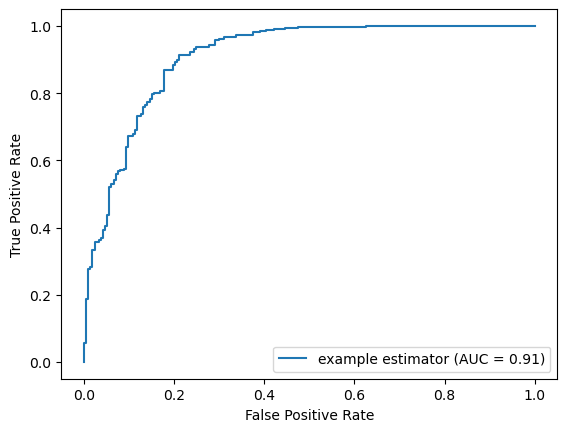

In [123]:
model = get_conv_model(200,64, 0.4,0.3)

opt = keras.optimizers.Nadam(learning_rate=0.001)
model.compile(
    optimizer=opt,
    loss=keras.losses.binary_crossentropy,
    metrics=["accuracy"])

checkpoint_filepath = '/home/shared/model_checkpoint_paige/scan/conv1d-kfold_0'+str(fold)

model.load_weights(checkpoint_filepath)
test_version(model,x_test,y_test)


In [8]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics

tf.config.experimental.enable_op_determinism()

def test_version(model, x_test, y_test, offset=0):

    y_pred = model(x_test, training=False)
        
    y_pred = y_pred.numpy() + offset
    cm = confusion_matrix(y_test, y_pred.round())
        
    sepecifity = cm[1][1]/(cm[1][1]+cm[1][0])
    sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
    accuracy = (cm[1][1]+cm[0][0])/(cm[1][1]+cm[1][0]+cm[0][0]+cm[0][1])

    ppv = cm[0][0]/(cm[0][0]+cm[1][0])
    npv = cm[1][1]/(cm[1][1]+cm[0][1])
    loss = metrics.log_loss(y_test, y_pred)

    print('Sensitivity:{:.4}'.format(sensitivity*100),
          '\nSpecificity:{:.4}'.format(sepecifity*100),
          '\nPPV:{:.4}'.format(ppv*100),
          '\nNPV:{:.4}'.format(npv*100),
          '\nAccuracy:{:.4}'.format(accuracy*100),
          '\nLoss:{:.4}'.format(loss))
    print(cm)

    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=1)
    roc_auc = metrics.auc(fpr, tpr)
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                      estimator_name='example estimator')
    display.plot()

    # plt.show()

In [74]:
seq_len=208

for fold in range(0,9):

    model = get_attn_lstm(seq_len)

    np_dir = '/home/shared/nps/coat_np_0'

    batch_size = 1
    gen = get_generators(files, fold, batch_size, 'tot', 'feats', True, 
                         seq_len=seq_len, np_dir=np_dir, crop=False,
                         osa=False, test_only = True)
    
    t_len = gen.__len__()
    x_test = np.zeros([t_len,208,num_features])
    y_test = np.zeros([t_len,1])
    for i in range(0,t_len):
        x_test[i], y_test[i]= gen.__getitem__(i)
        
    lr = 0.001
    opt = keras.optimizers.Nadam(learning_rate=lr)
    model.compile(
            optimizer=opt,
            loss=keras.losses.binary_crossentropy,
            metrics=["accuracy",]
        )

#     if fold != 9:
    checkpoint_filepath = '/home/shared/model_checkpoint_paige/scan/reg5-kfold_0'+str(fold)
#     else:
#         checkpoint_filepath = '/home/shared/model_checkpoint_paige/scan/reg-kfold_0'+str(fold)
    model.load_weights(checkpoint_filepath).expect_partial()
    
    y_pred = model(x_test, training=False)
    
    files['pred'+ str(fold)] = y_pred

In [119]:
def get_slope(y_true, y_pred, a, step):
    y_alt = (y_pred + a - step/2).round()
    cm = confusion_matrix(y_true, y_alt)

    sp0 = cm[1][1]/(cm[1][1]+cm[1][0])
    se0 = cm[0][0]/(cm[0][0]+cm[0][1])
    
    val0 = sp0+se0
    
    y_alt = (y_pred + a + step/2)
    cm = confusion_matrix(y_true, y_alt)

    sp1 = cm[1][1]/(cm[1][1]+cm[1][0])
    se1 = cm[0][0]/(cm[0][0]+cm[0][1])
    
    val1 = sp1+se1
    
    return (val1 - val0)/step

In [155]:
def get_slope_even(y_true, y_pred, a, step):
    y_alt = (y_pred + a - step/2).round()
    cm = confusion_matrix(y_true, y_alt)

    sp0 = cm[1][1]/(cm[1][1]+cm[1][0])
    se0 = cm[0][0]/(cm[0][0]+cm[0][1])
    
    val0 = sp0-se0
    
    y_alt = (y_pred + a + step/2).round()
    cm = confusion_matrix(y_true, y_alt)

    sp1 = cm[1][1]/(cm[1][1]+cm[1][0])
    se1 = cm[0][0]/(cm[0][0]+cm[0][1])
    
    val1 = sp1-se1

    return np.sign(val0 - val1)*(np.abs(val1) - np.abs(val0))/step

In [241]:
alts = np.zeros([10])
for fold in range(0,10):
    train_files = files[files.fold != fold]
    y_true = train_files.negative_exam_for_pe
    y_pred = train_files['pred'+str(fold)]
    lr = 0.01
    alt = 0
    for i in range(100):
#         g = get_slope_npv(y_true, y_pred, alt, 0.02)
#         alt = alt + g * lr
        g = get_slope(y_true,y_pred ,alt, 0.02)
        alt = alt + g * lr
        
    alts[fold] = alt
    cm = confusion_matrix(y_true, y_pred.round())
    sp0 = cm[1][1]/(cm[1][1]+cm[1][0])
    se0 = cm[0][0]/(cm[0][0]+cm[0][1])
    a0 = (cm[1][1]+cm[0][0])/(cm[1][1]+cm[1][0]+cm[0][0]+cm[0][1])

    
    cm = confusion_matrix(y_true, (y_pred + alt).round())
    sp1 = cm[1][1]/(cm[1][1]+cm[1][0])
    se1 = cm[0][0]/(cm[0][0]+cm[0][1])
    a1 = (cm[1][1]+cm[0][0])/(cm[1][1]+cm[1][0]+cm[0][0]+cm[0][1])
    
    print(str(fold) + '   Original: {:.3f}, {:.3f}, {:.3f}, {:.3f},\n    New:      {:.3f}, {:.3f}, {:.3f}, {:.3f}'.format(sp0,se0,a0,sp0+se0,sp1,se1,a1,sp1+se1) )

0   Original: 0.916, 0.830, 0.887, 1.745,
    New:      0.930, 0.819, 0.894, 1.749
1   Original: 0.889, 0.836, 0.872, 1.726,
    New:      0.912, 0.820, 0.882, 1.731
2   Original: 0.904, 0.859, 0.889, 1.763,
    New:      0.905, 0.858, 0.890, 1.763
3   Original: 0.916, 0.790, 0.875, 1.707,
    New:      0.916, 0.791, 0.875, 1.707
4   Original: 0.924, 0.848, 0.899, 1.772,
    New:      0.923, 0.850, 0.899, 1.773
5   Original: 0.929, 0.858, 0.906, 1.787,
    New:      0.929, 0.858, 0.906, 1.787
6   Original: 0.899, 0.824, 0.874, 1.723,
    New:      0.908, 0.818, 0.879, 1.727
7   Original: 0.890, 0.785, 0.856, 1.675,
    New:      0.891, 0.785, 0.857, 1.676
8   Original: 0.899, 0.820, 0.874, 1.720,
    New:      0.900, 0.819, 0.874, 1.720
9   Original: 0.893, 0.792, 0.860, 1.684,
    New:      0.908, 0.781, 0.867, 1.690


(array([4157]),) 4.234042762318868e-05
(array([5465]),) 1.7508753505371564
(array([8185, 8211, 8212, 8213, 8214, 8230]),) 0.899682857619763


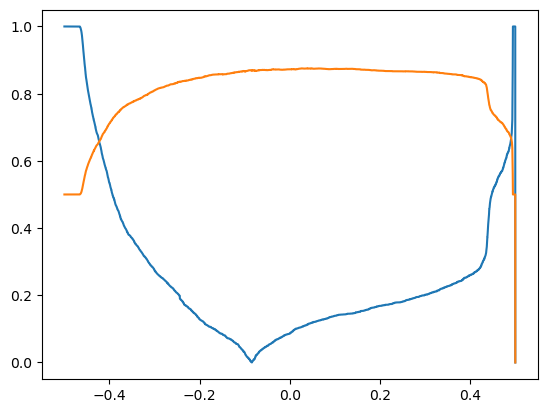

(array([4462, 4463, 4464, 4465, 4466, 4467, 4468, 4469, 4470]),) 0.00011619473630253285
(array([5778, 5779]),) 1.7329647504661079
(array([7537, 7539, 7540, 7546, 7547, 7548, 7549, 7550, 7551, 7552, 7553,
       7554, 7555, 7556, 7557, 7558, 7559, 7560, 7561, 7562, 7563, 7569,
       7570, 7571]),) 0.8938761888870349


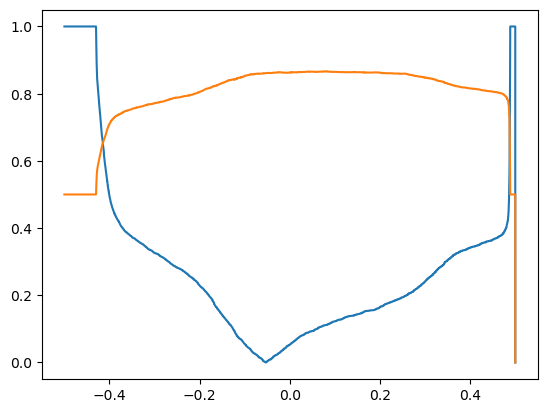

(array([4406]),) 0.00020878576599225873
(array([5068, 5069, 5070, 5071]),) 1.7638427248828439
(array([6906, 6907, 6908, 6909, 6910, 6911]),) 0.9069806279225117


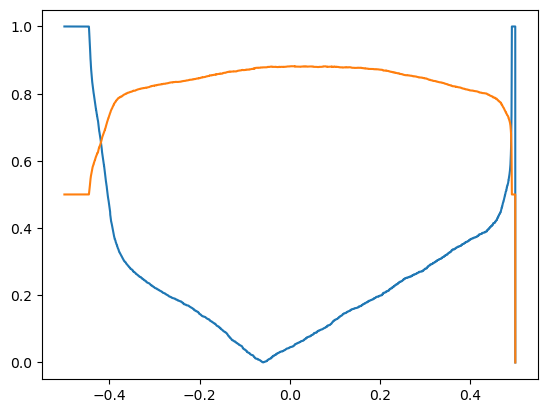

(array([3407, 3408, 3409, 3410, 3411, 3412, 3413, 3414, 3415, 3416, 3417,
       3418, 3419, 3420, 3421, 3422]),) 9.140358153059136e-05
(array([4380, 4381, 4382]),) 1.7113992512228702
(array([6676]),) 0.8825883922615076


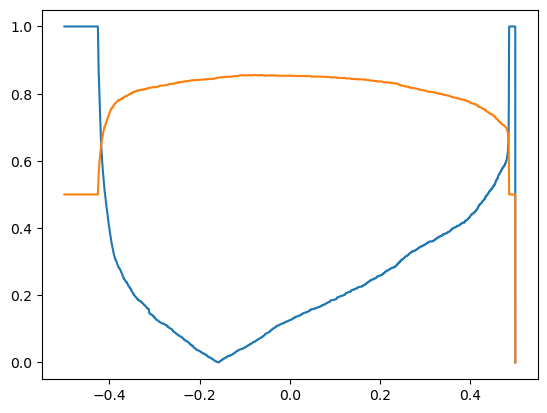

(array([3096, 3097, 3098, 3099, 3100, 3101]),) 0.00011616087181076651
(array([4485, 4486, 4487, 4488, 4489, 4490, 4491, 4492, 4493, 4494, 4495,
       4496, 4497, 4498, 4499, 4500, 4501, 4502, 4503, 4504, 4505, 4506,
       4507, 4508, 4509, 4510, 4511, 4512, 4513, 4514, 4515, 4516, 4517,
       4518, 4519, 4520, 4521, 4522]),) 1.7739030381566343
(array([7033, 7034, 7035]),) 0.9062969767830299


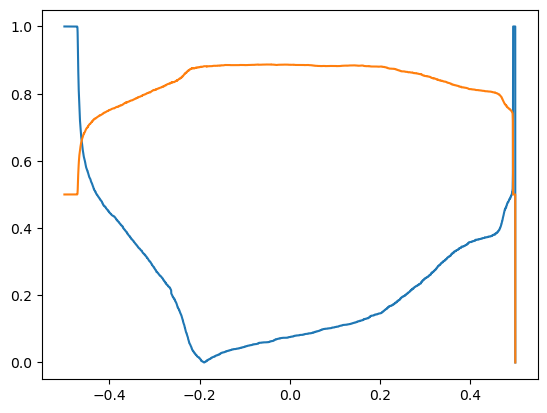

(array([3413, 3414, 3415, 3416, 3417, 3418, 3419, 3420, 3421, 3422, 3423,
       3424, 3425]),) 0.00017747687049118888
(array([4464, 4465, 4466, 4467, 4468, 4469, 4470, 4471, 4472, 4473, 4474,
       4475, 4476, 4477, 4478, 4479, 4480]),) 1.790457331602386
(array([6342, 6343, 6346, 6611, 6612, 6613, 6614, 6615, 6616, 6617, 6618,
       6619, 6620, 6621, 6622, 6623, 6624, 6625, 6649, 6650, 6651, 6652,
       6653, 6654, 6710, 6711, 6712, 6713, 6714, 6715, 6716, 6717, 6718,
       6719, 6720, 6721, 6722, 6723, 6724, 6725, 6726, 6727, 6728, 6729,
       6730, 6731, 6732, 6733, 6734, 6735, 6736]),) 0.9127315201067913


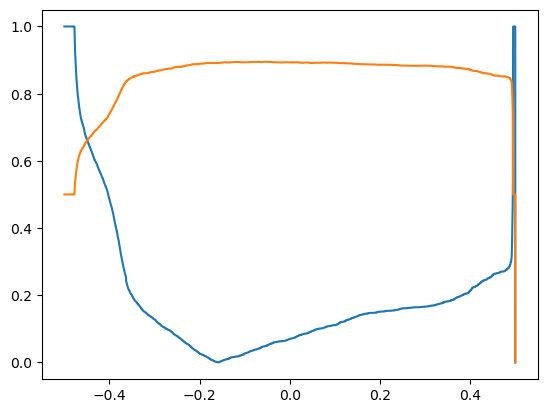

(array([3287, 3288]),) 8.449727275594565e-05
(array([5372, 5373, 5374, 5375, 5376, 5377, 5378, 5379, 5380, 5381, 5382,
       5383]),) 1.7273424346564932
(array([7488, 7489, 7490]),) 0.8920767306088407


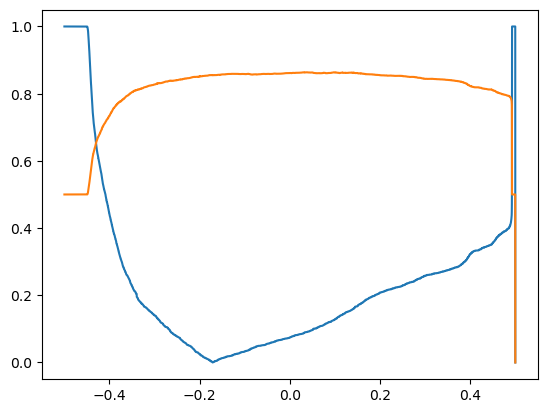

(array([3777, 3778, 3779]),) 0.00011270450002032195
(array([5587, 5588, 5589, 5590, 5591]),) 1.6803272000326386
(array([7611, 7612, 7613, 7614]),) 0.8792125458792125


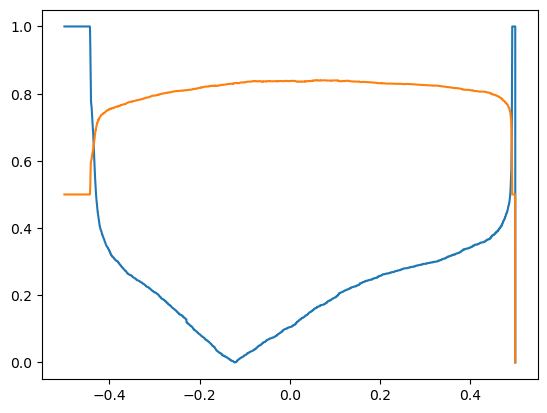

(array([3741, 3742, 3743, 3744, 3745, 3746, 3747]),) 0.00015982333179631603
(array([5420]),) 1.7216499095285782
(array([8508, 8509, 8510, 8511, 8512, 8513, 8514, 8515, 8516, 8517, 8518,
       8519, 8520, 8735, 8736, 8737, 8738, 8739, 8740, 8790]),) 0.8895562228895563


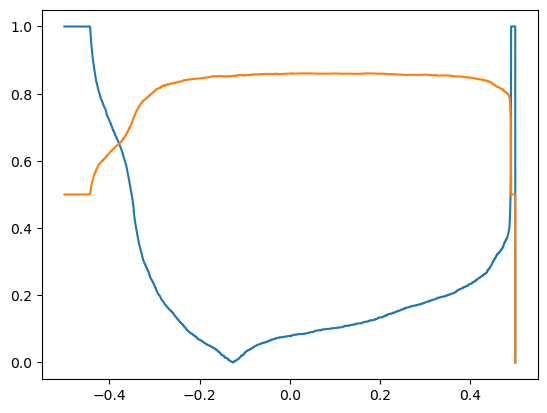

(array([3332, 3333, 3334]),) 8.863568754291506e-05
(array([5663, 5664, 5665, 5666]),) 1.692255751619218
(array([7776]),) 0.8801535636788516


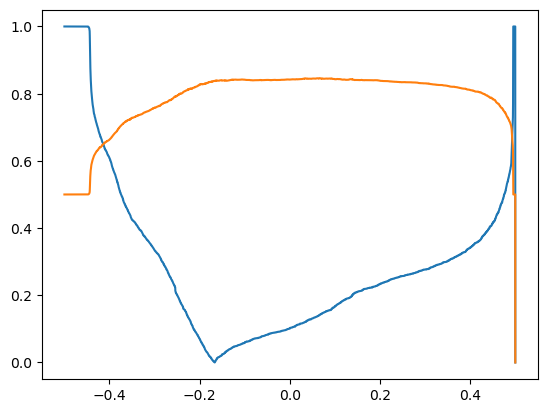

In [306]:
best = np.zeros([10,3,2])
best[:,1,0] = 1
for fold in range(0,10):
    train_files = files[files.fold != fold]
    y_true = train_files.negative_exam_for_pe
    y_pred = train_files['pred'+str(fold)]

    mindiff = np.zeros([9998])
    maxtot = np.zeros([9998])
    acurs = np.zeros([9998])
    

    for i in np.arange(-0.4999,0.4999,0.0001):
        y_orig = (y_pred +i).round()
        cm = confusion_matrix(y_true, y_orig)
        sp0 = cm[1][1]/(cm[1][1]+cm[1][0])
        se0 = cm[0][0]/(cm[0][0]+cm[0][1])

        ppv = cm[0][0]/(cm[0][0]+cm[1][0])
        npv = cm[1][1]/(cm[1][1]+cm[0][1])
        acu = (cm[1][1]+cm[0][0])/(cm[1][1]+cm[1][0]+cm[0][0]+cm[0][1])
        
        mindiff[int(i*10000 + 4999)] = np.abs(sp0 - se0)
        maxtot[int(i*10000 + 4999)] = sp0 + se0
        acurs[int(i*10000 + 4999)] = acu
        
    mini = mindiff[:9990].min()
    print(np.where(mindiff == mini), mini)
    
    maxi = maxtot.max()
    print(np.where(maxtot == maxi), maxi)
    
    maxu = acurs.max()
    print(np.where(acurs == maxu), maxu)

    
    best[fold,0,0] = maxi
    best[fold,0,1] = np.mean(np.where(maxtot == maxi))
    
    best[fold,1,0] = mini
    best[fold,1,1] = np.mean(np.where(mindiff == mini))
    
    best[fold,2,0] = maxu
    best[fold,2,1] = np.mean(np.where(acurs == mini))

        
    plt.plot(np.arange(-0.4999,0.4999,0.0001),mindiff)
    plt.plot(np.arange(-0.4999,0.4999,0.0001),maxtot/2)
    plt.show()

In [349]:
alts = best[:,1,1]/10000

In [ ]:
alts = np.zeros([10])
for fold in range(0,10):
    train_files = files[files.fold != fold]
    y_true = train_files.negative_exam_for_pe
    y_pred = train_files['pred'+str(fold)]
    lr = 0.001
    alt = 0
    for i in range(100):
        g = get_slope_npv(y_true, y_pred, alt, 0.02)
        alt = alt + g * lr
        if np.abs(alt) > 0.5:
            break
        
    alts[fold] = alt
    cm = confusion_matrix(y_true, y_pred.round())
    sp0 = cm[1][1]/(cm[1][1]+cm[1][0])
    se0 = cm[0][0]/(cm[0][0]+cm[0][1])
    a0 = (cm[1][1]+cm[0][0])/(cm[1][1]+cm[1][0]+cm[0][0]+cm[0][1])
    n0 = cm[1][1]/(cm[1][1]+cm[0][1])


    
    cm = confusion_matrix(y_true, (y_pred + alt).round())
    sp1 = cm[1][1]/(cm[1][1]+cm[1][0])
    se1 = cm[0][0]/(cm[0][0]+cm[0][1])
    a1 = (cm[1][1]+cm[0][0])/(cm[1][1]+cm[1][0]+cm[0][0]+cm[0][1])
    n1 = cm[1][1]/(cm[1][1]+cm[0][1])

    
    print(str(fold) + '   Original: {:.3f}, {:.3f}, {:.3f}, {:.3f}, {:.3f},\n    New:      {:.3f}, {:.3f}, {:.3f}, {:.3f}, {:.3f}'.format(sp0,se0,a0,sp0+se0,n0,sp1,se1,a1,sp1+se1,n1) )

In [353]:
1-alts

array([0.5843 , 0.5534 , 0.5594 , 0.65855, 0.69015, 0.6581 , 0.67125,
       0.6222 , 0.6256 , 0.6667 ])

In [351]:
for fold in range(0,10):
    train_files = files[files.fold != fold]
    y_true = train_files.negative_exam_for_pe
    y_pred = (train_files['pred'+str(fold)] - 0.5 +alts[fold]).round()
    
    cm = confusion_matrix(y_true, y_pred)
        
    sepecifity = cm[1][1]/(cm[1][1]+cm[1][0])
    sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
    accuracy = (cm[1][1]+cm[0][0])/(cm[1][1]+cm[1][0]+cm[0][0]+cm[0][1])
    print(fold, sepecifity, sensitivity, accuracy, sensitivity+sepecifity)

0 0.8687095166915795 0.8694992412746586 0.8689701218494408 1.738208757966238
1 0.8609665427509293 0.8610827374872319 0.8610045052561321 1.7220492802381613
2 0.8781575037147102 0.8784615384615385 0.8782565130260521 1.7566190421762489
3 0.8479285537087571 0.8478371501272265 0.847898599066044 1.6957657038359835
4 0.881781981085117 0.8816658202133062 0.8817437781860699 1.7634478012984232
5 0.8913151364764268 0.891492613346918 0.8913732688136159 1.7828077498233448
6 0.8549068322981367 0.8553299492385786 0.8550458715596331 1.7102367815367154
7 0.8309547244094488 0.8310880829015544 0.8309976643309976 1.6620428073110034
8 0.8529048207663782 0.8527449974345819 0.8528528528528528 1.70564981820096
9 0.8380386329866271 0.8381976446492575 0.8380904690368887 1.6762362776358846


In [229]:
tot.to_csv('all_val_ans.csv')

In [58]:
seq_len=208
dos5 = pd.DataFrame(columns=['fold','auc','sensitivity', 'specificity', 'accuracy','npv','ppv'])
tot = 0
caught = 0

no = 0
nope = 0

plt.figure(0).clf()
tot = pd.DataFrame(columns=files_test.columns)
tot['pred'] = -1
for fold in range(0,10):

    model = get_attn_lstm(seq_len)

    np_dir = '/home/shared/nps/coat_np_0'

    batch_size = 1
    test_files = files[files.fold == fold]
    test_gen = get_generators(test_files, fold, 
                                   batch_size, 
                                   'tot', 
                                   'feats', 
                                   True, 
                                   seq_len=seq_len, 
                                   np_dir=np_dir, 
                                   crop=False,
                                   test_only=True,
                                   osa=False)
    
    
    t_len = test_gen.__len__()
    x_test = np.zeros([t_len,208,num_features])
    y_test = np.zeros([t_len,1])
    for i in range(0,t_len):
        x_test[i],y= test_gen.__getitem__(i)
        y_test[i] = y
        
    lr = 0.001
    opt = keras.optimizers.Nadam(learning_rate=lr)
    model.compile(
            optimizer=opt,
            loss=keras.losses.binary_crossentropy,
            metrics=["accuracy",]
        )

    checkpoint_filepath = '/home/shared/model_checkpoint_paige/scan/reg5-kfold_0'+str(fold)
#     else:
#         checkpoint_filepath = '/home/shared/model_checkpoint_paige/scan/reg-kfold_0'+str(fold)
    model.load_weights(checkpoint_filepath).expect_partial()
    
    ys = model.predict(x_test)
    test_files['pred'] = ys
    tot = pd.concat([tot, test_files])

<Figure size 640x480 with 0 Axes>

Sensitivity:79.69 
Specificity:89.13 
PPV:78.07 
NPV:90.04 
Accuracy:86.05 
Loss:0.3583
[[1734  442]
 [ 487 3995]]
0.905819407121952


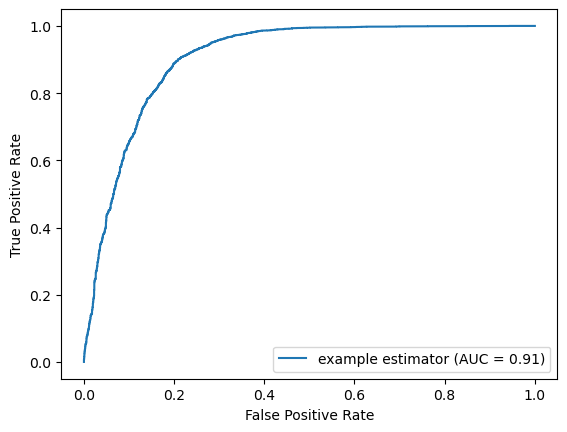

In [65]:
y_test = tot.negative_exam_for_pe.astype(int)
y_pred = tot.pred
cm = confusion_matrix(y_test, y_pred.round())

sepecifity = cm[1][1]/(cm[1][1]+cm[1][0])
sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
accuracy = (cm[1][1]+cm[0][0])/(cm[1][1]+cm[1][0]+cm[0][0]+cm[0][1])

ppv = cm[0][0]/(cm[0][0]+cm[1][0])
npv = cm[1][1]/(cm[1][1]+cm[0][1])
loss = metrics.log_loss(y_test, y_pred)

print('Sensitivity:{:.4}'.format(sensitivity*100),
      '\nSpecificity:{:.4}'.format(sepecifity*100),
      '\nPPV:{:.4}'.format(ppv*100),
      '\nNPV:{:.4}'.format(npv*100),
      '\nAccuracy:{:.4}'.format(accuracy*100),
      '\nLoss:{:.4}'.format(loss))
print(cm)

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=1)
roc_auc = metrics.auc(fpr, tpr)
print(roc_auc)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='example estimator')
display.plot()

In [76]:
tot[tot.chronic_pe == True].mean()

negative_exam_for_pe          0.000000
qa_motion                     0.000000
qa_contrast                   0.000000
flow_artifact                 0.028777
rv_lv_ratio_gte_1             0.517986
rv_lv_ratio_lt_1              0.482014
leftsided_pe                  0.719424
chronic_pe                    1.000000
true_filling_defect_not_pe    0.007194
rightsided_pe                 0.776978
acute_and_chronic_pe          0.000000
central_pe                    0.129496
indeterminate                 0.000000
fold                          4.553957
pred                          0.443458
score                         0.521583
dtype: float64

In [84]:
len(tot[(tot.chronic_pe == True) & (tot.score == 0)])/len(tot[tot.chronic_pe == True])

0.4784172661870504

In [92]:
tot.chronic_pe.sum()

278

In [85]:
len(tot[(tot.rightsided_pe == True) & (tot.score == 0)])/len(tot[tot.rightsided_pe == True])

0.1654054054054054

In [86]:
len(tot[(tot.leftsided_pe == True) & (tot.score == 0)])/len(tot[tot.leftsided_pe == True])

0.16228646517739817

In [87]:
tot[(tot.negative_exam_for_pe == True) & (tot.true_filling_defect_not_pe)].mean()

negative_exam_for_pe          1.000000
qa_motion                     0.000000
qa_contrast                   0.000000
flow_artifact                 0.129032
rv_lv_ratio_gte_1             0.000000
rv_lv_ratio_lt_1              0.000000
leftsided_pe                  0.000000
chronic_pe                    0.000000
true_filling_defect_not_pe    1.000000
rightsided_pe                 0.000000
acute_and_chronic_pe          0.000000
central_pe                    0.000000
indeterminate                 0.000000
fold                          4.161290
pred                          0.675914
score                         0.258065
dtype: float64

In [91]:
tot[(tot.negative_exam_for_pe == False) & (tot.flow_artifact)].mean()

negative_exam_for_pe          0.000000
qa_motion                     0.000000
qa_contrast                   0.000000
flow_artifact                 1.000000
rv_lv_ratio_gte_1             0.375000
rv_lv_ratio_lt_1              0.625000
leftsided_pe                  0.687500
chronic_pe                    0.125000
true_filling_defect_not_pe    0.046875
rightsided_pe                 0.765625
acute_and_chronic_pe          0.078125
central_pe                    0.093750
indeterminate                 0.000000
fold                          4.687500
pred                          0.369322
score                         0.625000
dtype: float64

In [89]:
tot[(tot.negative_exam_for_pe == True) & (tot.flow_artifact)].mean()

negative_exam_for_pe          1.000000
qa_motion                     0.000000
qa_contrast                   0.000000
flow_artifact                 1.000000
rv_lv_ratio_gte_1             0.000000
rv_lv_ratio_lt_1              0.000000
leftsided_pe                  0.000000
chronic_pe                    0.000000
true_filling_defect_not_pe    0.021739
rightsided_pe                 0.000000
acute_and_chronic_pe          0.000000
central_pe                    0.000000
indeterminate                 0.000000
fold                          4.619565
pred                          0.708678
score                         0.163043
dtype: float64

In [90]:
tot[(tot.negative_exam_for_pe == True)].mean()

negative_exam_for_pe          1.000000
qa_motion                     0.000000
qa_contrast                   0.000000
flow_artifact                 0.041053
rv_lv_ratio_gte_1             0.000000
rv_lv_ratio_lt_1              0.000000
leftsided_pe                  0.000000
chronic_pe                    0.000000
true_filling_defect_not_pe    0.006917
rightsided_pe                 0.000000
acute_and_chronic_pe          0.000000
central_pe                    0.000000
indeterminate                 0.000000
fold                          4.454261
pred                          0.786981
score                         0.108657
dtype: float64

In [80]:
len(tot[tot.chronic_pe == True])/len(tot[tot.negative_exam_for_pe == False])

0.12775735294117646

In [83]:
tot[(tot.negative_exam_for_pe == False) & (tot.pred > 0.5)].mean()

negative_exam_for_pe          0.000000
qa_motion                     0.000000
qa_contrast                   0.000000
flow_artifact                 0.054299
rv_lv_ratio_gte_1             0.312217
rv_lv_ratio_lt_1              0.687783
leftsided_pe                  0.558824
chronic_pe                    0.300905
true_filling_defect_not_pe    0.013575
rightsided_pe                 0.692308
acute_and_chronic_pe          0.038462
central_pe                    0.024887
indeterminate                 0.000000
fold                          4.628959
pred                          0.777939
score                         0.000000
dtype: float64

In [125]:
pos = tot[tot.negative_exam_for_pe == False]
cols = ['flow_artifact','rv_lv_ratio_gte_1','rv_lv_ratio_lt_1','leftsided_pe','chronic_pe','true_filling_defect_not_pe','rightsided_pe','acute_and_chronic_pe','central_pe']
for col in cols:
    ARt = (1-pos[pos[col]==True].score).mean()
    ARc = (1-pos[pos[col]==False].score).mean()
    print(col + '   Pos: {:.3f},   Neg: {:.3f},   RR {:.3f}'.format(ARt*100, ARc*100, ARt/ARc*100))
    print()
ARt = (1-pos[pos.central_pe==False].score).mean()
ARc = (1-pos[pos.central_pe==True].score).mean()
print('Not Central   Pos: {:.3f},   Neg: {:.3f},   RR {:.3f}'.format(ARt*100, ARc*100, ARt/ARc*100))
print()

ARt = (1-pos[(pos.central_pe == False) & (pos.leftsided_pe ^ pos.rightsided_pe)].score).mean()
ARc = (1-pos[~((pos.central_pe == False) & (pos.leftsided_pe ^ pos.rightsided_pe))].score).mean()
print('Both   Pos: {:.3f},   Neg: {:.3f},   RR {:.3f}'.format(ARt*100, ARc*100, ARt/ARc*100))
print()

ARt = (1-pos[(pos.central_pe == False) & (pos.leftsided_pe == False)].score).mean()
ARc = (1-pos[(pos.central_pe == False) & (pos.leftsided_pe)].score).mean()
print('No Central Left   Pos: {:.3f},   Neg: {:.3f},   RR {:.3f}'.format(ARt*100, ARc*100, ARt/ARc*100))
print()

ARt = (1-pos[(pos.central_pe == False) & (pos.rightsided_pe ==False)].score).mean()
ARc = (1-pos[(pos.central_pe == False) & (pos.rightsided_pe)].score).mean()
print('No Central Right   Pos: {:.3f},   Neg: {:.3f},   RR {:.3f}'.format(ARt*100, ARc*100, ARt/ARc*100))
print()

flow_artifact   Pos: 37.500,   Neg: 19.792,   RR 189.474

rv_lv_ratio_gte_1   Pos: 14.887,   Neg: 24.339,   RR 61.163

rv_lv_ratio_lt_1   Pos: 24.339,   Neg: 14.887,   RR 163.498

leftsided_pe   Pos: 16.229,   Neg: 29.817,   RR 54.428

chronic_pe   Pos: 47.842,   Neg: 16.280,   RR 293.863

true_filling_defect_not_pe   Pos: 27.273,   Neg: 20.241,   RR 134.737

rightsided_pe   Pos: 16.541,   Neg: 41.718,   RR 39.649

acute_and_chronic_pe   Pos: 11.888,   Neg: 20.905,   RR 56.867

central_pe   Pos: 2.757,   Neg: 24.254,   RR 11.367

Not Central   Pos: 24.254,   Neg: 2.757,   RR 879.772

Both   Pos: 35.065,   Neg: 9.425,   RR 372.045

No Central Left   Pos: 30.844,   Neg: 20.758,   RR 148.589

No Central Right   Pos: 43.506,   Neg: 20.218,   RR 215.189



In [204]:
col = 'chronic_pe'
(pos[pos[col] == False].score.mean())/(pos[pos[col] == True].score.mean())

1.6051088259874278

In [208]:
col = 'central_pe'
print(pos[pos[col] == True].score.mean()/pos[pos[col] == False].score.mean(), pos[pos[col] == True].score.mean(), pos[pos[col] == False].score.mean())

1.2838113113392695 0.9724310776942355 0.7574563871693866


In [209]:
col = 'rv_lv_ratio_gte_1'
print(pos[pos[col] == True].score.mean()/pos[pos[col] == False].score.mean(), pos[pos[col] == True].score.mean(), pos[pos[col] == False].score.mean())

1.1249362168456019 0.8511326860841424 0.7566052842273819


In [221]:
len(fn[(fn.rv_lv_ratio_lt_1 == True) | (fn.chronic_pe == True) | ((fn.leftsided_pe == True) & (fn.central_pe == False) & (fn.rightsided_pe == False)) | ((fn.rightsided_pe == True) & (fn.central_pe == False) & (fn.leftsided_pe == False))])/len(fn)

0.9479638009049773

In [227]:
len(pos[(pos.leftsided_pe == True) & (pos.central_pe == False) & (pos.rightsided_pe == False)])

308

In [226]:
len(pos[(pos.leftsided_pe == False) & (pos.central_pe == False) & (pos.rightsided_pe == True)])

616

In [222]:
len(fn[(fn.rv_lv_ratio_lt_1 == True) | (fn.chronic_pe == True) | (fn.central_pe == False)])/len(fn)

0.997737556561086

In [216]:
pos[(pos.leftsided_pe == True) & (pos.central_pe==False) & (pos.rightsided_pe == False)].mean()

negative_exam_for_pe          0.000000
qa_motion                     0.000000
qa_contrast                   0.000000
flow_artifact                 0.048701
rv_lv_ratio_gte_1             0.279221
rv_lv_ratio_lt_1              0.720779
leftsided_pe                  1.000000
chronic_pe                    0.191558
true_filling_defect_not_pe    0.012987
rightsided_pe                 0.000000
acute_and_chronic_pe          0.022727
central_pe                    0.000000
indeterminate                 0.000000
fold                          4.392857
pred                          0.429796
score                         0.564935
dtype: float64

In [211]:
pos[pos.chronic_pe == True].mean()

negative_exam_for_pe          0.000000
qa_motion                     0.000000
qa_contrast                   0.000000
flow_artifact                 0.028777
rv_lv_ratio_gte_1             0.517986
rv_lv_ratio_lt_1              0.482014
leftsided_pe                  0.719424
chronic_pe                    1.000000
true_filling_defect_not_pe    0.007194
rightsided_pe                 0.776978
acute_and_chronic_pe          0.000000
central_pe                    0.129496
indeterminate                 0.000000
fold                          4.553957
pred                          0.443458
score                         0.521583
dtype: float64

In [134]:
tot.columns
neg = tot[tot.negative_exam_for_pe == True]
cols = ['flow_artifact','true_filling_defect_not_pe']
for col in cols:
    ARt = (neg[neg[col]==True].score).mean()
    ARc = (neg[neg[col]==False].score).mean()
    print(col + '   Pos: {:.3f},   Neg: {:.3f},   RR {:.3f}'.format(ARt*100, ARc*100, ARt/ARc*100))
    print()

flow_artifact   Pos: 16.304,   Neg: 10.633,   RR 153.339

true_filling_defect_not_pe   Pos: 25.806,   Neg: 10.762,   RR 239.801



In [146]:
len(neg[(neg.score == 1) & (neg.flow_artifact | neg.true_filling_defect_not_pe)])/len(neg[neg.score == 1])

0.07392197125256673

In [147]:
neg[neg.score == 1].mean()

negative_exam_for_pe          1.000000
qa_motion                     0.000000
qa_contrast                   0.000000
flow_artifact                 0.061602
rv_lv_ratio_gte_1             0.000000
rv_lv_ratio_lt_1              0.000000
leftsided_pe                  0.000000
chronic_pe                    0.000000
true_filling_defect_not_pe    0.016427
rightsided_pe                 0.000000
acute_and_chronic_pe          0.000000
central_pe                    0.000000
indeterminate                 0.000000
fold                          4.246407
pred                          0.274205
score                         1.000000
dtype: float64

In [165]:
1- len(fn[~((fn.chronic_pe == True) | (fn.rv_lv_ratio_lt_1 == True) | ((fn.leftsided_pe==True) ^ (fn.rightsided_pe ==True)))])/len(fn)

0.9502262443438914

In [185]:
len(fn[(fn.central_pe == False) & (fn.leftsided_pe ^ fn.rightsided_pe)])/len(fn)

0.7330316742081447

In [171]:
fn[(fn.central_pe == True) & (fn.rv_lv_ratio_gte_1 == True) & (fn.chronic_pe == False)]

,file_name,StudyInstanceUID,negative_exam_for_pe,qa_motion,qa_contrast,flow_artifact,rv_lv_ratio_gte_1,rv_lv_ratio_lt_1,leftsided_pe,chronic_pe,true_filling_defect_not_pe,rightsided_pe,acute_and_chronic_pe,central_pe,indeterminate,fold,pred,score
2551,5e698a8957cf.npy,5e698a8957cf,0,0,0,0,1,0,0,0,0,1,0,1,0,3,0.899338,0.0


In [160]:
pos[pos.rv_lv_ratio_gte_1 == True].mean()

negative_exam_for_pe          0.000000
qa_motion                     0.000000
qa_contrast                   0.000000
flow_artifact                 0.025890
rv_lv_ratio_gte_1             1.000000
rv_lv_ratio_lt_1              0.000000
leftsided_pe                  0.813376
chronic_pe                    0.155340
true_filling_defect_not_pe    0.009709
rightsided_pe                 0.901834
acute_and_chronic_pe          0.080906
central_pe                    0.307443
indeterminate                 0.000000
fold                          4.596548
pred                          0.157926
score                         0.851133
dtype: float64

In [136]:
neg.score.sum(), neg.negative_exam_for_pe.sum()

(487.0, 4482)